## Raking of the AllOfUs Survey Data on N Variables

This notebook performs raking on N simultaneous variables (N >= 2). Weights are computed for an unweighted source sample so that specified marginal distributions match those of a weighted target population.

The source and target datasets **must** obey an identical coding scheme, which is found in the file `src/coding_aou.py`.

The target population is that specified by the PUMS data release. The PUMS data files and the associated codebook can be found here: https://www.census.gov/programs-surveys/acs/data/experimental-data/2020-1-year-pums.html . The recoded PUMS file is generated by the `PUMS-Recoding.ipynb` notebook.

In [1]:
import os
import re
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ipfn import ipfn
from collections import Counter, defaultdict

from src import plots, pdf, models

# coding file - ensure that the input files were generated with the selected coding scheme
from src import coding_aou as CODING

### User Parameters

In [2]:
# Identifiers for the variables to be raked (from the coding file) - also specifies their ordering.
# *** The ordering of the variables affects the raking metric. ***

RAKE_DATA = [
    # variable enum,              # recoded AOU var name,      # recoded PUMS var name
    (CODING.Variables.AGE,        'Age',                       'Age'),          
    (CODING.Variables.RACE_ETH,   'RaceEth',                   'RaceEth'),
    (CODING.Variables.INSURANCE,  'Insurance',                 'Insurance'),
    (CODING.Variables.EDUCATION,  'Education',                 'Education'),
    (CODING.Variables.INCOME,     'Income',                    'Income'),  
    (CODING.Variables.SEX,        'Sex',                       'Sex'),        
]

# directory where the source and target recoded input files are located
DATA_DIR = 'data'

# recoded PUMS file for all 50 states and DC
PUMS_RECODED_FILE_NAME = 'pums_usa_2020_recoded_aou.csv'

# name of the synthetic AOU data
AOU_RECODED_FILE_NAME = 'synthetic_aou.csv'

# a weighted version of the source file will be written to DATA_DIR
OUTPUT_FILE_NAME = 'aou_weighted.csv'

# Whether to use weighted PUMS counts, which are required for true population counts (PUMS 'PWGTP' variable).
# Set to None to use an unweighted target population.
PUMS_WEIGHT_COL = 'PWGTP'

# Which state(s) to use as the raking target(s), specified as a list of strings representing PUMS state codes.
# If multiple states are specified, all data from those states will be used to build the contingency table.
# Specify a list of state codes as follows, using strings representing either single integers or ranges:
#         PUMS_STATE_CODES = ['6','12','20-24','48']
# To use all available state codes, set this variable to None.
PUMS_STATE_CODES = ['13'] # GA

# Number of simple random source samples to use; set to None to use all source data.
SOURCE_SAMPLE_COUNT = 6140

# seed for the random number generator; set to None to use a random 128-bit seed
# (only needed if not using all source samples)
RNG_SEED = None

### End of User Input

#### Initialize the random number generator

In [3]:
rng = np.random.default_rng(RNG_SEED)

# print the seed for reference
print('RNG seed: {0}'.format(rng._bit_generator._seed_seq.entropy))

RNG seed: 40874093614829735156692004545157832799


#### Setup some parameters

In [4]:
# list of enumerate variables to be raked
RAKEVARS = [tup[0] for tup in RAKE_DATA]

# map of variable enum to source file col name
AOU_COL_MAP = {RAKEVARS[i]:RAKE_DATA[i][1] for i in range(len(RAKEVARS))}

# map of variable enum to PUMS file col name
PUMS_COL_MAP = {RAKEVARS[i]:RAKE_DATA[i][2] for i in range(len(RAKEVARS))}

# get the names of the variables, in order
RAKEVAR_NAMES = [CODING.VAR_NAMES[enumvar] for enumvar in RAKEVARS]
RAKEVAR_NAMES

['Age', 'RaceEth', 'Insurance', 'Education', 'Income', 'Sex']

#### Input Files

Construct paths to the input files relative to this notebook.

In [5]:
# recoded PUMS file for the entire USA
TARGET_FILE = os.path.join(DATA_DIR, PUMS_RECODED_FILE_NAME)

# source file
SOURCE_FILE = os.path.join(DATA_DIR, AOU_RECODED_FILE_NAME)

print('Target file: {0}'.format(TARGET_FILE))
print('Source file: {0}'.format(SOURCE_FILE))

Target file: data/pums_usa_2020_recoded_aou.csv
Source file: data/synthetic_aou.csv


#### Load the Target File

In [6]:
print('Loading target file "{0}"...'.format(TARGET_FILE))
pums_usa_df = pd.read_csv(TARGET_FILE)
pums_usa_df

Loading target file "data/pums_usa_2020_recoded_aou.csv"...


,Age,Education,Income,Insurance,PWGTP,RaceEth,SERIALNO,SPORDER,ST,Sex
0,5,0,3,0,32,0,2020HU0989848,1,1,1
1,5,0,2,0,84,0,2020HU0723924,2,1,1
2,0,0,0,0,72,0,2020HU0724020,1,1,0
3,0,2,0,1,73,0,2020HU0724020,2,1,0
4,0,1,0,0,102,4,2020HU0724093,1,1,1
...,...,...,...,...,...,...,...,...,...,...
2053274,2,1,2,1,193,3,2020HU0745188,2,56,1
2053275,2,0,1,0,56,0,2020HU0745709,1,56,1
2053276,2,0,1,0,52,0,2020HU0745709,2,56,0
2053277,0,2,2,0,150,0,2020HU0745861,2,56,0


#### Extract data for the specified states

In [7]:
# build list of desired state codes
state_codes = []
if PUMS_STATE_CODES is None:
    # use all available codes
    pums_df = pums_usa_df.copy()
else:
    for item in PUMS_STATE_CODES:
        if item.isdigit():
            # single state code
            code = int(item.strip())
            state_codes.append(code)
        else:
            # must be a range
            assert '-' in item
            first, last = item.split('-')
            first = int(first.strip())
            last  = int(last.strip())
            for code in range(first, last+1):
                state_codes.append(code)
    
    # check that all state codes represent actual states (or DC)
    for code in state_codes:
        assert code >= pums_usa_df['ST'].min()
        assert code <= pums_usa_df['ST'].max()
    
    # extract all rows for these states
    pums_df = pums_usa_df.loc[pums_usa_df['ST'].isin(state_codes)]

# keep specified data cols and weight col, drop all others
keep_cols = [col for col in PUMS_COL_MAP.values()]
keep_cols.append(PUMS_WEIGHT_COL)
pums_df = pums_df[keep_cols]
pums_df = pums_df.reset_index(drop=True)
pums_df

,Age,RaceEth,Insurance,Education,Income,Sex,PWGTP
0,2,0,0,2,2,0,60
1,3,0,0,0,3,0,58
2,2,4,0,0,3,1,56
3,4,0,0,1,0,0,100
4,4,0,0,2,0,1,129
...,...,...,...,...,...,...,...
49749,4,0,0,0,2,1,406
49750,6,0,0,2,0,0,90
49751,2,3,0,0,1,1,172
49752,2,0,0,0,2,0,142


In [8]:
# get the names of the target columns in the same order as the RAKEVARS array
ordered_target_cols = [PUMS_COL_MAP[enumvar] for enumvar in RAKEVARS]
print('Target columns, in order: {0}\n'.format(ordered_target_cols))

# samples taken in order of the variables in VARIABLES
TARGET_SAMPLES = [np.array(pums_df[col].values) for col in ordered_target_cols]

# set TARGET_WEIGHTS to None to rake to an unweighted target population
if PUMS_WEIGHT_COL is not None:
    TARGET_WEIGHTS = np.array(pums_df[PUMS_WEIGHT_COL].values)
    TARGET_POPULATION = np.sum(TARGET_WEIGHTS)
    print('Target population (weighted): {0}'.format(TARGET_POPULATION))
else:
    TARGET_WEIGHTS = None
    TARGET_POPULATION = len(TARGET_SAMPLES[0])    
    print('Target population (unweighted): {0}'.format(TARGET_POPULATION))

Target columns, in order: ['Age', 'RaceEth', 'Insurance', 'Education', 'Income', 'Sex']

Target population (weighted): 7928097


#### Load the Source File

In [9]:
raw_source_df = pd.read_csv(SOURCE_FILE)

# extract required cols
cols = [c for c in AOU_COL_MAP.values()]
source_df = raw_source_df[cols]

# do simple random samlpling without replacement to match desired sample count
if SOURCE_SAMPLE_COUNT is not None:
    source_df = source_df.sample(SOURCE_SAMPLE_COUNT, replace=False, random_state = rng)
    
source_df

,Age,RaceEth,Insurance,Education,Income,Sex
87252,4,1,0,2,3,0
48652,3,1,0,1,0,0
3197,4,1,1,0,0,0
112542,1,0,0,0,0,1
72659,2,1,0,0,3,0
...,...,...,...,...,...,...
66462,4,1,0,1,0,1
85971,3,0,0,0,0,0
17816,0,4,0,0,3,1
87188,4,1,0,2,3,0


In [10]:
# get the names of the source dataframe columns in the order matching the variables
ordered_source_cols = [AOU_COL_MAP[enumvar] for enumvar in RAKEVARS]
print('Source columns, in order: {0}\n'.format(ordered_source_cols))

# build a list of np.arrays containing the data for each col
SOURCE_SAMPLES = [np.array(source_df[col].values) for col in ordered_source_cols]

print('Sample population: {0}'.format(len(SOURCE_SAMPLES[0])))

Source columns, in order: ['Age', 'RaceEth', 'Insurance', 'Education', 'Income', 'Sex']

Sample population: 6140


#### Compute the number of bins required to hold each variable

Categorical values for a given variable are **assumed** to be a contiguous block of integers starting at 0.

In [11]:
# bin counts in order of the variables
BIN_COUNTS = []

for enumvar in RAKEVARS:
    BIN_COUNTS.append(CODING.BIN_COUNTS[enumvar])

# maximum-length variable name, used for prettyprinting
maxlen = max([len(var_name) for var_name in RAKEVAR_NAMES])

print('Bin counts: ')
for i in range(len(RAKEVAR_NAMES)):
    print('{0:>{2}} : {1}'.format(RAKEVAR_NAMES[i], BIN_COUNTS[i], maxlen))

Bin counts: 
      Age : 8
  RaceEth : 5
Insurance : 3
Education : 5
   Income : 5
      Sex : 3


#### Useful plotting function

In [12]:
def plot_pdfs(source_unraked_pdfs, source_raked_pdfs, target_pdfs):
    
    # display precision
    P = 5
    
    num_pdfs = len(source_unraked_pdfs)
    assert len(source_raked_pdfs) == len(target_pdfs) == num_pdfs
    
    for q in range(0, num_pdfs):
        plots.triple_histogram_from_pdfs(RAKEVAR_NAMES[q], 
                                         source_unraked_pdfs[q], source_raked_pdfs[q], target_pdfs[q],
                                         labels=['Unraked Source', 'Raked Source', 'Target'])
        print('Unraked source PDF : {0}'.format(np.array_str(source_unraked_pdfs[q], precision=P)))
        print('  Raked source PDF : {0}'.format(np.array_str(source_raked_pdfs[q],   precision=P)))
        print('        Target PDF : {0}'.format(np.array_str(target_pdfs[q],         precision=P)))

## Raking in N Dimensions

Rake samples for N variables for source and target so that the source marginals match the target marginals.

The marginals to be matched are set by the raking model.

In [13]:
def contingency_table(sample_arrays, bin_counts, weights=None):
    """
    Construct an contingency table from the sample arrays.
    
    The parameter 'sample_arrays' is a list of numpy arrays, all of identical length. Each array contains
    the samples for one of the variables.
    
    The parameter 'bin_counts' is a list of integers, one for each array in the sample_arrays list.
    
    ASSUMPTIONS:
        1. Samples are categorical with values represented by a contiguous group of integers starting at zero.
        2. Each array of samples contains the same number of elements.
        3. The sample_arrays and bin_counts arrays have the same number of elements.
    """
    
    # need an array for each bin
    assert len(sample_arrays) == len(bin_counts)

    # all arrays in samples have identical length (derived from dataframe)
    num_samples = len(sample_arrays[0])

    # ensure that the weights array has the same length as the sample arrays
    if weights is not None:
        assert len(weights) == num_samples
        
    # table of counts
    table = np.zeros(tuple(bin_counts))
    
    # fill table
    for q in range(num_samples):
        
        # build index tuple from the qth element of each sample array
        index_tup = tuple([sample_arrays[i][q] for i in range(len(sample_arrays))])
    
        w = 1
        if weights is not None:
            w = weights[q]
            
        table[index_tup] += w
        
    # check counts
    total = np.sum(table)
    if weights is None:
        assert np.isclose(total, num_samples)
    else:
        assert np.isclose(total, np.sum(weights))
    
    return table

In [14]:
def compute_marginals(model, table):
    """
    Compute marginals for raking using the index specifications in 'model', which is a list of lists.
            
    A valid model should ensure that each axis appears at least once, with no repeats in any sub-list.
    """
    
    # convert model to tuples for hashing
    tup_model = [tuple(item) for item in model]
        
    marginals = []
    for marginal_axes in tup_model:
        
        # determine axes to be summed over
        dim = len(table.shape)
        sum_axes = {q for q in range(dim)}
        for a in marginal_axes:
            # remove the axes for the current marginal
            sum_axes.remove(a)
            
        # convert to tuple if more than one axis, integer if not
        if len(sum_axes) > 1:
            sum_axes = tuple(sum_axes)
        else:
            sum_axes = sum_axes.pop()

        # compute the marginal for this set of marginal axes
        marginal = np.sum(table, axis=sum_axes)
        marginals.append(marginal)
        
    assert len(marginals) == len(model)
    return marginals

In [15]:
def sample_weights(sample_arrays, raked, unraked, target_pop):
    """
    Compute weights for each individual in the source dataframe.
    """

    # each variable has an identical number of samples
    num_samples = len(sample_arrays[0])
        
    # weights for individual cells
    cell_weights = np.divide(raked, unraked)
    
    # set NaNs to zero (occur where unraked == 0, so get a divide by zero)
    cell_weights[np.isnan(cell_weights)] = 0
    assert not np.isnan(cell_weights).any()
        
    # compute weighted sample - should sum to target population
    weighted_sample = np.multiply(cell_weights, unraked)
    weighted_sample_pop = np.sum(weighted_sample)
    if not np.isclose(weighted_sample_pop, target_pop):
        # these weights are no good
        population_diff_pct = 100.0 * np.abs(target_pop - weighted_sample_pop) / target_pop
        print('\tWeighted population differs from target by {0:.2f}%, discarding...'.format(population_diff_pct))
        return None

    # extract weights from table using recoded data as coords    
    weights = []
    for q in range(num_samples):
        
        # build index tuple from the qth element of each sample array
        index_tup = tuple([sample_arrays[i][q] for i in range(len(sample_arrays))])
        
        # get the weight from this cell
        w = cell_weights[index_tup]
        weights.append(w)
        
    # need one weight for each row in the source dataframe
    assert len(weights) == num_samples
        
    # sum of the weights should sum to target population
    assert np.isclose(target_pop, np.sum(weights))
    return np.array(weights)

In [16]:
def rake(model, source_samples, target_samples, target_weights, bin_counts):
    """
    Parameters:
    
        source_samples: list of numpy arrays, one for each variable
        target_samples: list of numpy arrays, one for each variable
        target_weights: list of weights, one for each row in the target dataframe
    """   
    
    # must have one weight for each row of the target
    assert len(target_weights) == len(target_samples[0])
    
    # compute the target population, either weighted or unweighted
    if target_weights is None:
        target_n = len(target_samples[0])
    else:
        target_n = np.sum(target_weights)
        assert target_n == TARGET_POPULATION
    
    # generate the source table
    table_s = contingency_table(source_samples, bin_counts)
        
    # generate the target table
    table_t = contingency_table(target_samples, bin_counts, target_weights)
    
    # compute the target marginals for this raking model
    marginals_t = compute_marginals(model, table_t)
    
    # make a copy of the unraked table, otherwise will be overwritten by ipfn
    unraked = table_s.copy()
    
    # do the iterations
    ipf_obj = ipfn.ipfn(original         = table_s,
                        aggregates       = marginals_t,
                        dimensions       = model,
                        convergence_rate = 1e-6,
                        max_iteration    = 5000,
                        verbose          = 2)
    raked, flag, info = ipf_obj.iteration()
    
    # a flag value of "1" means convergence
    if 1 == flag:

        # compute weights for each row of the source dataframe
        weights = sample_weights(source_samples, raked, unraked, target_n)
        if weights is not None:
            
            # compute error metric: compute the marginals for the raked data and compare with target
            marginals_r = compute_marginals(model, raked)

            # accumulate sum of squared residuals here
            sum_sq = 0.0
            for index, marginal in enumerate(marginals_r):

                # Compute the difference array between the result marginal and the target marginal.
                # All elements should be essentially zero.
                diff = marginal - marginals_t[index]

                # Compute the sum of the squares of each element of the diff matrix.
                # This is *elementwise* multiplication, not matrix multiplication.
                residual = np.sum(np.multiply(diff, diff))
                sum_sq += residual

            # Frobenius norm
            fnorm = np.sqrt(sum_sq)

            return weights, unraked, table_t, raked, fnorm

    return None, None, None, None, None            

## Search for the Best Raking Model

In [17]:
def check_models(dim, model_list):
    """
    A model is a list of lists, such as [[0], [1,2], [2,3,4], [5]].
    
    This function performs a set of consistency and correctness checks on all models in "model_list".
    """
    
    invalid_models = []
    for m in model_list:
        
        # a valid model must include all indices on the interval [0, dim)
        required_index_set = {i for i in range(dim)}
        
        # this is the set of all axes in the current model
        member_set = set()
        
        for member_list in m:
            for elt in member_list:
                assert elt in required_index_set
                
            # member lists cannot contain duplicate indices
            ctr = Counter(member_list)
            for v in ctr.values():
                assert 1 == v
            
            # update the set of all axes in the current model
            for elt in member_list:
                member_set.add(elt)
                
        # these sets must be equal for a valid model
        diff_set = required_index_set - member_set
        if 0 != len(diff_set):
            print('*** Invalid model: {0} ***'.format(m))
            invalid_models.append(m)
            
    return invalid_models

In [18]:
dim = len(RAKEVARS)
if 2 == dim:
    MODELS = models.MODELS_2
elif 3 == dim:
    MODELS = models.MODELS_3
elif 4 == dim:
    MODELS = models.MODELS_4
elif 5 == dim:
    MODELS = models.MODELS_5
elif 6 == dim:
    MODELS = models.MODELS_6
else:
    # just use 1D marginals
    MODELS = [
        [[i] for i in range(dim)],
    ]
    
invalid_models = check_models(dim, MODELS)

# find the model having the *minimum* value of the worst fnorm
# (i.e. find the worst variable triplet in the best-performing model)
best_model_index = 0
min_worst_fnorm = sys.float_info.max

# saved results
weights = None
unraked = None
target  = None
raked   = None
fnorm   = None

score_map = {}

for index, model in enumerate(MODELS):
    
    print('[{0}/{1}]\tRaking Model {2}:\n'.format(index+1, len(MODELS), model))
    if model in invalid_models:
        print('\tInvalid model, skipping...')
        continue
        
    weights_m, unraked_m, target_m, raked_m, fnorm_m = rake(model,
                                                            SOURCE_SAMPLES,
                                                            TARGET_SAMPLES, TARGET_WEIGHTS,
                                                            BIN_COUNTS)
    # save if converged
    if fnorm_m is None:
        print('\tF-Norm : DID NOT CONVERGE\n')
    else: 
        print('\tF-Norm : {0:.3f}\n'.format(fnorm_m))
        score_map[fnorm_m] = model

        # update params for best model
        if fnorm_m < min_worst_fnorm:
            min_worst_fnorm = fnorm_m
            best_model_index = index
            weights = weights_m
            unraked = unraked_m
            target  = target_m
            raked   = raked_m
            fnorm   = fnorm_m

[1/69]	Raking Model [[0], [1], [2], [3], [4], [5]]:

ipfn converged: convergence_rate below threshold
	F-Norm : 0.050

[2/69]	Raking Model [[0], [1], [2], [3], [4, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	F-Norm : 0.012

[3/69]	Raking Model [[0], [1], [2], [4], [3, 5]]:

ipfn converged: convergence_rate below threshold
	F-Norm : 0.016

[4/69]	Raking Model [[0], [1], [3], [4], [2, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	F-Norm : 0.048

[5/69]	Raking Model [[0], [2], [3], [4], [1, 5]]:

ipfn converged: convergence_rate below threshold
	F-Norm : 0.022

[6/69]	Raking Model [[1], [2], [3], [4], [0, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 0.57%, discarding...
	F-Norm : DID NOT CONVERGE

[7/69]	Raking Model [[0], [1], [2], [5], [3, 4]]:

ipfn converged: convergence_rate below threshold
	F-Norm : 0.046

[8/69]	Raking Model [[0], [1], [3], [5], [2, 4]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	F-Norm : 0.083

[9/69]	Raking Model [[0], [2], [3], [5], [1, 4]]:

ipfn converged: convergence_rate below threshold
	F-Norm : 0.013

[10/69]	Raking Model [[1], [2], [3], [5], [0, 4]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 0.31%, discarding...
	F-Norm : DID NOT CONVERGE

[11/69]	Raking Model [[0], [1], [4], [5], [2, 3]]:

ipfn converged: convergence_rate below threshold
	F-Norm : 0.107

[12/69]	Raking Model [[0], [2], [4], [5], [1, 3]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	F-Norm : 0.055

[13/69]	Raking Model [[1], [2], [4], [5], [0, 3]]:

ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 0.74%, discarding...
	F-Norm : DID NOT CONVERGE

[14/69]	Raking Model [[0], [3], [4], [5], [1, 2]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	F-Norm : 0.010

[15/69]	Raking Model [[1], [3], [4], [5], [0, 2]]:

ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 0.01%, discarding...
	F-Norm : DID NOT CONVERGE

[16/69]	Raking Model [[2], [3], [4], [5], [0, 1]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:


ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 0.69%, discarding...
	F-Norm : DID NOT CONVERGE

[17/69]	Raking Model [[3], [4], [5], [0, 1, 2]]:

ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 0.69%, discarding...
	F-Norm : DID NOT CONVERGE

[18/69]	Raking Model [[2], [4], [5], [0, 1, 3]]:



/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 1.47%, discarding...
	F-Norm : DID NOT CONVERGE

[19/69]	Raking Model [[2], [3], [5], [0, 1, 4]]:

ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 0.73%, discarding...
	F-Norm : DID NOT CONVERGE

[20/69]	Raking Model [[2], [3], [4], [0, 1, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 0.82%, discarding...
	F-Norm : DID NOT CONVERGE

[21/69]	Raking Model [[1], [4], [5], [0, 2, 3]]:

ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 0.74%, discarding...
	F-Norm : DID NOT CONVERGE

[22/69]	Raking Model [[1], [3], [5], [0, 2, 4]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 0.32%, discarding...
	F-Norm : DID NOT CONVERGE

[23/69]	Raking Model [[1], [3], [4], [0, 2, 5]]:

ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 0.58%, discarding...
	F-Norm : DID NOT CONVERGE

[24/69]	Raking Model [[1], [2], [5], [0, 3, 4]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 0.80%, discarding...
	F-Norm : DID NOT CONVERGE

[25/69]	Raking Model [[1], [2], [4], [0, 3, 5]]:

ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 0.82%, discarding...
	F-Norm : DID NOT CONVERGE

[26/69]	Raking Model [[1], [2], [3], [0, 4, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 0.72%, discarding...
	F-Norm : DID NOT CONVERGE

[27/69]	Raking Model [[0], [4], [5], [1, 2, 3]]:

ipfn converged: convergence_rate below threshold
	F-Norm : 0.075

[28/69]	Raking Model [[0], [3], [5], [1, 2, 4]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	F-Norm : 0.079

[29/69]	Raking Model [[0], [4], [3], [1, 2, 5]]:

ipfn converged: convergence_rate below threshold
	F-Norm : 0.067

[30/69]	Raking Model [[0], [2], [5], [1, 3, 4]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	F-Norm : 0.031

[31/69]	Raking Model [[0], [2], [4], [1, 3, 5]]:

ipfn converged: convergence_rate below threshold
	F-Norm : 0.062

[32/69]	Raking Model [[0], [2], [3], [1, 4, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	F-Norm : 0.065

[33/69]	Raking Model [[0], [1], [5], [2, 3, 4]]:

ipfn converged: convergence_rate below threshold
	F-Norm : 0.015

[34/69]	Raking Model [[0], [1], [4], [2, 3, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	F-Norm : 0.023

[35/69]	Raking Model [[0], [1], [3], [2, 4, 5]]:

ipfn converged: convergence_rate below threshold
	F-Norm : 0.074

[36/69]	Raking Model [[0], [1], [2], [3, 4, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	F-Norm : 0.067

[37/69]	Raking Model [[4], [5], [0, 1, 2, 3]]:

ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 2.90%, discarding...
	F-Norm : DID NOT CONVERGE

[38/69]	Raking Model [[3], [5], [0, 1, 2, 4]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 1.54%, discarding...
	F-Norm : DID NOT CONVERGE

[39/69]	Raking Model [[3], [4], [0, 1, 2, 5]]:

ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 1.18%, discarding...
	F-Norm : DID NOT CONVERGE

[40/69]	Raking Model [[2], [5], [0, 1, 3, 4]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 4.33%, discarding...
	F-Norm : DID NOT CONVERGE

[41/69]	Raking Model [[2], [4], [0, 1, 3, 5]]:

ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 3.20%, discarding...
	F-Norm : DID NOT CONVERGE

[42/69]	Raking Model [[2], [3], [0, 1, 4, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 1.77%, discarding...
	F-Norm : DID NOT CONVERGE

[43/69]	Raking Model [[1], [5], [0, 2, 3, 4]]:

ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 0.86%, discarding...
	F-Norm : DID NOT CONVERGE

[44/69]	Raking Model [[1], [4], [0, 2, 3, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 0.82%, discarding...
	F-Norm : DID NOT CONVERGE

[45/69]	Raking Model [[1], [3], [0, 2, 4, 5]]:

ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 0.72%, discarding...
	F-Norm : DID NOT CONVERGE

[46/69]	Raking Model [[1], [2], [0, 3, 4, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 0.86%, discarding...
	F-Norm : DID NOT CONVERGE

[47/69]	Raking Model [[0], [5], [1, 2, 3, 4]]:

ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 0.77%, discarding...
	F-Norm : DID NOT CONVERGE

[48/69]	Raking Model [[0], [4], [1, 2, 3, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 1.04%, discarding...
	F-Norm : DID NOT CONVERGE

[49/69]	Raking Model [[0], [3], [1, 2, 4, 5]]:

ipfn converged: convergence_rate below threshold
	F-Norm : 0.052

[50/69]	Raking Model [[0], [2], [1, 3, 4, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 0.11%, discarding...
	F-Norm : DID NOT CONVERGE

[51/69]	Raking Model [[0], [1], [2, 3, 4, 5]]:

ipfn converged: convergence_rate below threshold
	F-Norm : 0.062

[52/69]	Raking Model [[0, 1], [2, 3], [4, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate not updating or below rate_tolerance
	F-Norm : 51923.312

[53/69]	Raking Model [[0, 2], [1, 3], [4, 5]]:

ipfn converged: convergence_rate not updating or below rate_tolerance
	F-Norm : 13005.518

[54/69]	Raking Model [[0, 3], [1, 2], [4, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate not updating or below rate_tolerance
	F-Norm : 37613.841

[55/69]	Raking Model [[0, 4], [1, 2], [3, 5]]:

ipfn converged: convergence_rate not updating or below rate_tolerance
	F-Norm : 18788.998

[56/69]	Raking Model [[0, 5], [1, 2], [3, 4]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate not updating or below rate_tolerance
	F-Norm : 48070.341

[57/69]	Raking Model [[1, 2], [0, 3], [4, 5]]:

ipfn converged: convergence_rate not updating or below rate_tolerance
	F-Norm : 37525.765

[58/69]	Raking Model [[0, 1, 2], [3, 4, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate not updating or below rate_tolerance
	F-Norm : 50781.252

[59/69]	Raking Model [[0, 1, 3], [2, 4, 5]]:

ipfn converged: convergence_rate not updating or below rate_tolerance
	F-Norm : 54912.497

[60/69]	Raking Model [[0, 1, 4], [2, 3, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate not updating or below rate_tolerance
	F-Norm : 33159.634

[61/69]	Raking Model [[0, 2, 3], [1, 4, 5]]:

ipfn converged: convergence_rate not updating or below rate_tolerance
	F-Norm : 36404.452

[62/69]	Raking Model [[0, 2, 4], [1, 3, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate not updating or below rate_tolerance
	F-Norm : 19290.755

[63/69]	Raking Model [[0, 2, 5], [1, 3, 4]]:

ipfn converged: convergence_rate not updating or below rate_tolerance
	F-Norm : 46441.697

[64/69]	Raking Model [[0, 3, 5], [1, 2, 4]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate not updating or below rate_tolerance
	F-Norm : 29836.850

[65/69]	Raking Model [[0, 4, 5], [1, 2, 3]]:

ipfn converged: convergence_rate not updating or below rate_tolerance
	F-Norm : 38339.766

[66/69]	Raking Model [[0, 1, 2], [1, 2, 3], [2, 3, 4], [3, 4, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:


ipfn converged: convergence_rate not updating or below rate_tolerance
	F-Norm : 78073.716

[67/69]	Raking Model [[0, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4, 5]]:



/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:


ipfn converged: convergence_rate not updating or below rate_tolerance
	F-Norm : 110644.442

[68/69]	Raking Model [[0, 1, 2, 3, 4], [1, 2, 3, 4, 5]]:

ipfn converged: convergence_rate not updating or below rate_tolerance
	Weighted population differs from target by 2.17%, discarding...
	F-Norm : DID NOT CONVERGE

[69/69]	Raking Model [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5]]:



/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate not updating or below rate_tolerance
	F-Norm : 55965.065



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


In [19]:
print('\nTop five best-scoring raking models:\n')
print('\tVariables : {0}\n'.format([CODING.VAR_NAMES[enumvar] for enumvar in RAKEVARS]))
print('\t   F-Norm : Model')
sorted_scores = sorted(score_map.keys())[:5]
formatted_scores = ['{0:.3f}'.format(score) for score in sorted_scores]
max_digits = max(17, max([len(score) for score in formatted_scores]))
for i,score in enumerate(sorted_scores):
    print('{0:>{2}} : {1}'.format(formatted_scores[i], score_map[score], max_digits))
        
print('\n       Best model : {0}'.format(MODELS[best_model_index]))
print('Best model F-norm : {0:.3f}'.format(min_worst_fnorm))


Top five best-scoring raking models:

	Variables : ['Age', 'RaceEth', 'Insurance', 'Education', 'Income', 'Sex']

	   F-Norm : Model
            0.010 : [[0], [3], [4], [5], [1, 2]]
            0.012 : [[0], [1], [2], [3], [4, 5]]
            0.013 : [[0], [2], [3], [5], [1, 4]]
            0.015 : [[0], [1], [5], [2, 3, 4]]
            0.016 : [[0], [1], [2], [4], [3, 5]]

       Best model : [[0], [3], [4], [5], [1, 2]]
Best model F-norm : 0.010


## Compute PDFs for All Variables and Compare with Target

Run the best model again, compute PDFs for all variables, and check for zero diffs with the target.

In [20]:
model = MODELS[best_model_index]

weights, unraked, target, raked, fnorm = rake(model,
                                              SOURCE_SAMPLES,
                                              TARGET_SAMPLES, TARGET_WEIGHTS,
                                              BIN_COUNTS)
if fnorm is None:
    print('\n*** No acceptable raking model was found. ***')
else:
    # compute PDFs
    target_pdfs = {}
    source_raked_pdfs = {}
    source_unraked_pdfs = {}

    # target pdfs
    for q in range(len(RAKEVARS)):
        target_pdfs[q] = pdf.to_pdf(BIN_COUNTS[q], TARGET_SAMPLES[q], weights=TARGET_WEIGHTS)

    # unraked source pdfs
    for q in range(len(RAKEVARS)):
        source_unraked_pdfs[q] = pdf.to_pdf(BIN_COUNTS[q], SOURCE_SAMPLES[q], weights=None)

    # raked source pdfs
    for q in range(len(RAKEVARS)):
        source_raked_pdfs[q] = pdf.to_pdf(BIN_COUNTS[q], SOURCE_SAMPLES[q], weights=weights)

    print('\nPDF diffs after raking for model {0}:\n'.format(model))   

    # diff between raked and target pdfs
    diffs = []
    for q in range(len(RAKEVARS)):
        diff = source_raked_pdfs[q] - target_pdfs[q]
        diffs.append(diff)
        print('{0:>{2}} : {1}'.format(RAKEVAR_NAMES[q], 
                                      np.array_str(diff, precision=5, suppress_small=True),
                                      maxlen))

    # check the diff vectors for the presence of any diff > 0.01 (i.e. 1%)
    all_ok = True
    THRESHOLD = 0.01
    for diff_vector in diffs:
        if np.any(diff_vector > THRESHOLD):
            all_ok = False
    
    # sum of the weights
    sum_of_weights = np.sum(weights)
    print()
    print('Sum of the weights : {0:.3f}'.format(sum_of_weights))
    print('  Population total : {0:.3f}'.format(TARGET_POPULATION))
    print('        Difference : {0:.3f}'.format(abs(TARGET_POPULATION - sum_of_weights)))
    print('\nRaked PDFs differ from target PDFs by less than {0}%: {1}'.format(int(THRESHOLD * 100),
                                                                               all_ok))

/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/var/folders/vl/6vhvmnqs4511sw64d2hz4t2jfcvf3f/T/ipykernel_80569/2276923031.py:10: RuntimeWarning: invalid value encountered in true_divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold

PDF diffs after raking for model [[0], [3], [4], [5], [1, 2]]:

      Age : [-0.  0.  0.  0.  0.  0. -0. -0.]
  RaceEth : [ 0. -0.  0. -0.  0.]
Insurance : [ 0. -0.  0.]
Education : [ 0. -0. -0. -0.  0.]
   Income : [-0. -0.  0.  0.  0.]
      Sex : [-0.  0.  0.]

Sum of the weights : 7928097.000
  Population total : 7928097.000
        Difference : 0.000

Raked PDFs differ from target PDFs by less than 1%: True


## Plot 1D Distributions Before and After Raking

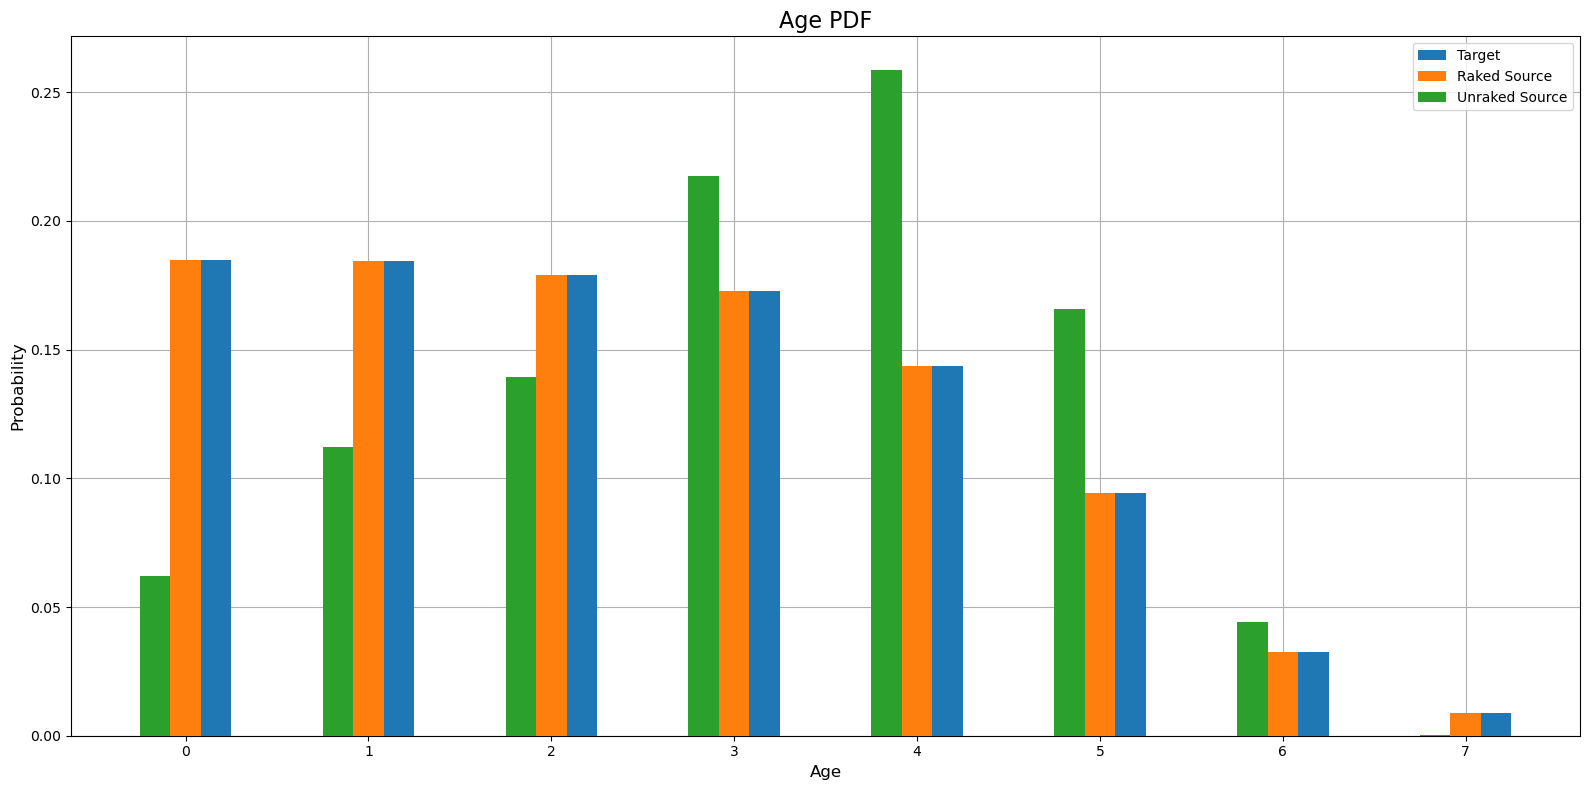

Unraked source PDF : [6.18893e-02 1.12052e-01 1.39414e-01 2.17590e-01 2.58795e-01 1.65961e-01
 4.41368e-02 1.62866e-04]
  Raked source PDF : [0.18465 0.18442 0.17897 0.17276 0.14349 0.09432 0.03266 0.00873]
        Target PDF : [0.18465 0.18442 0.17897 0.17276 0.14349 0.09432 0.03266 0.00873]


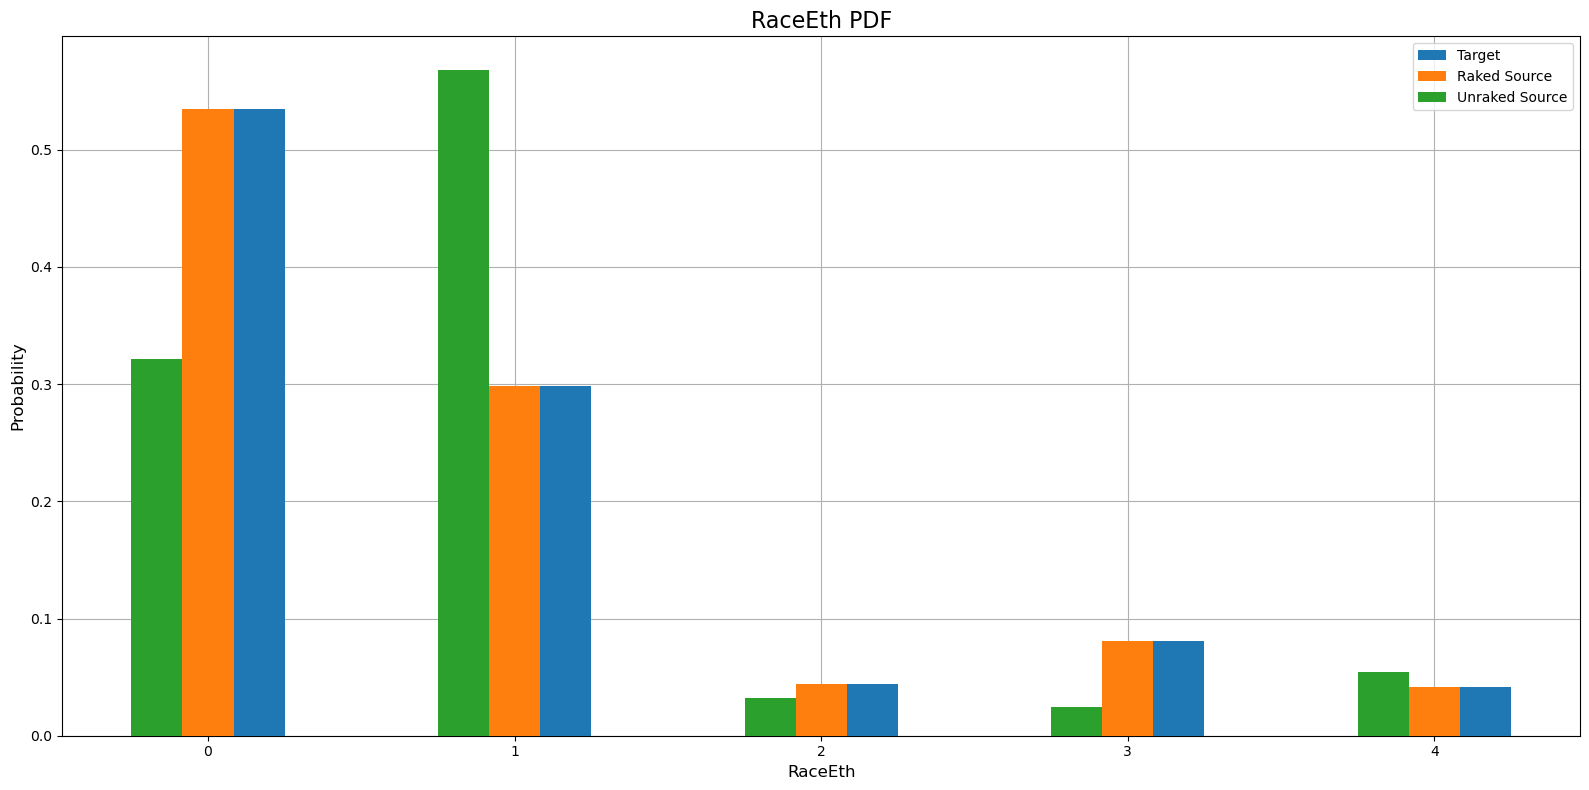

Unraked source PDF : [0.32101 0.56824 0.03176 0.02492 0.05407]
  Raked source PDF : [0.53501 0.29803 0.04427 0.0811  0.04159]
        Target PDF : [0.53501 0.29803 0.04427 0.0811  0.04159]


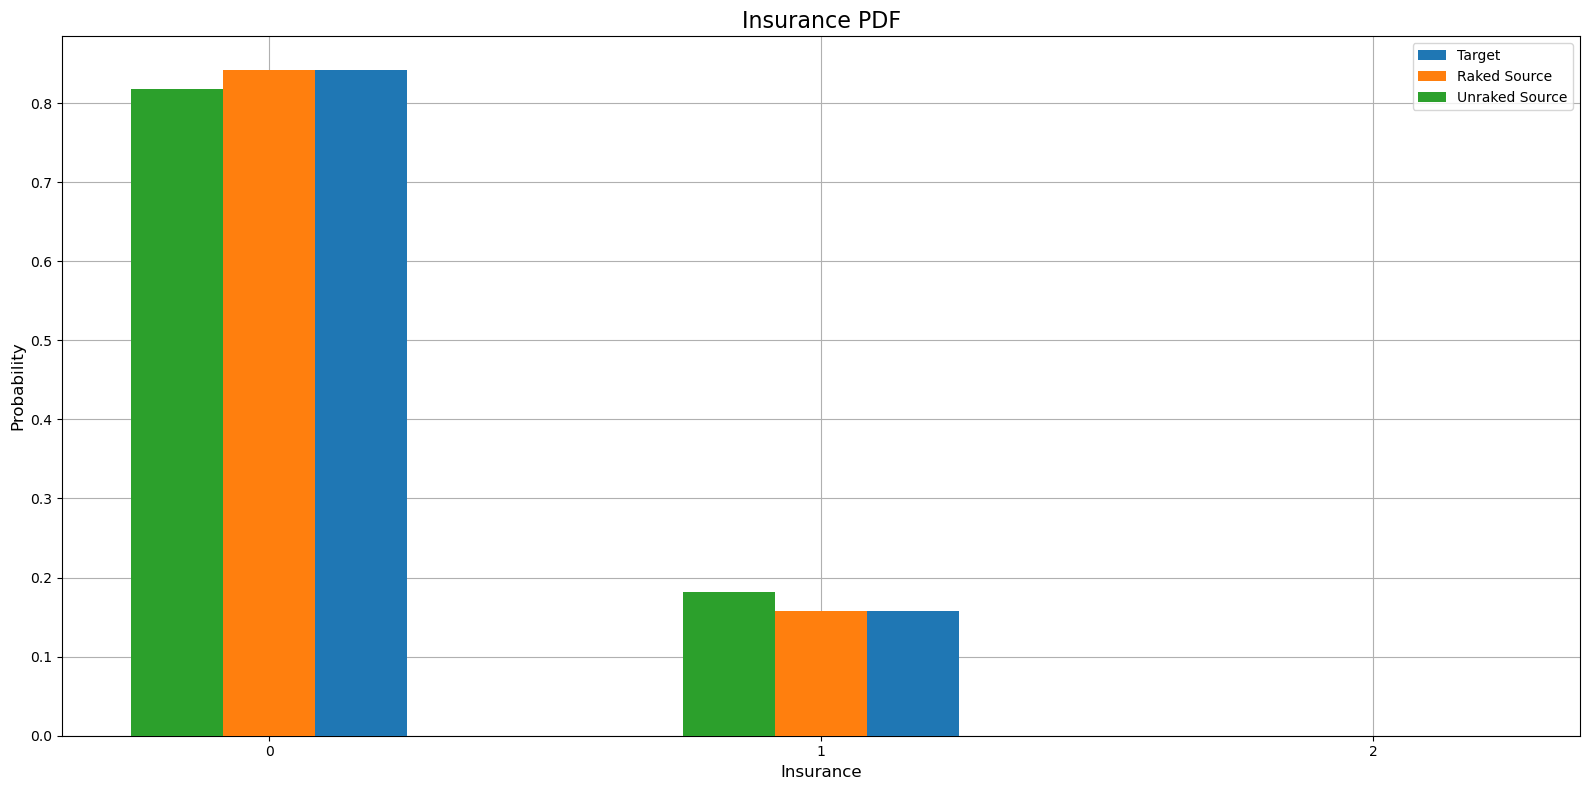

Unraked source PDF : [0.81792 0.18208 0.     ]
  Raked source PDF : [0.84223 0.15777 0.     ]
        Target PDF : [0.84223 0.15777 0.     ]


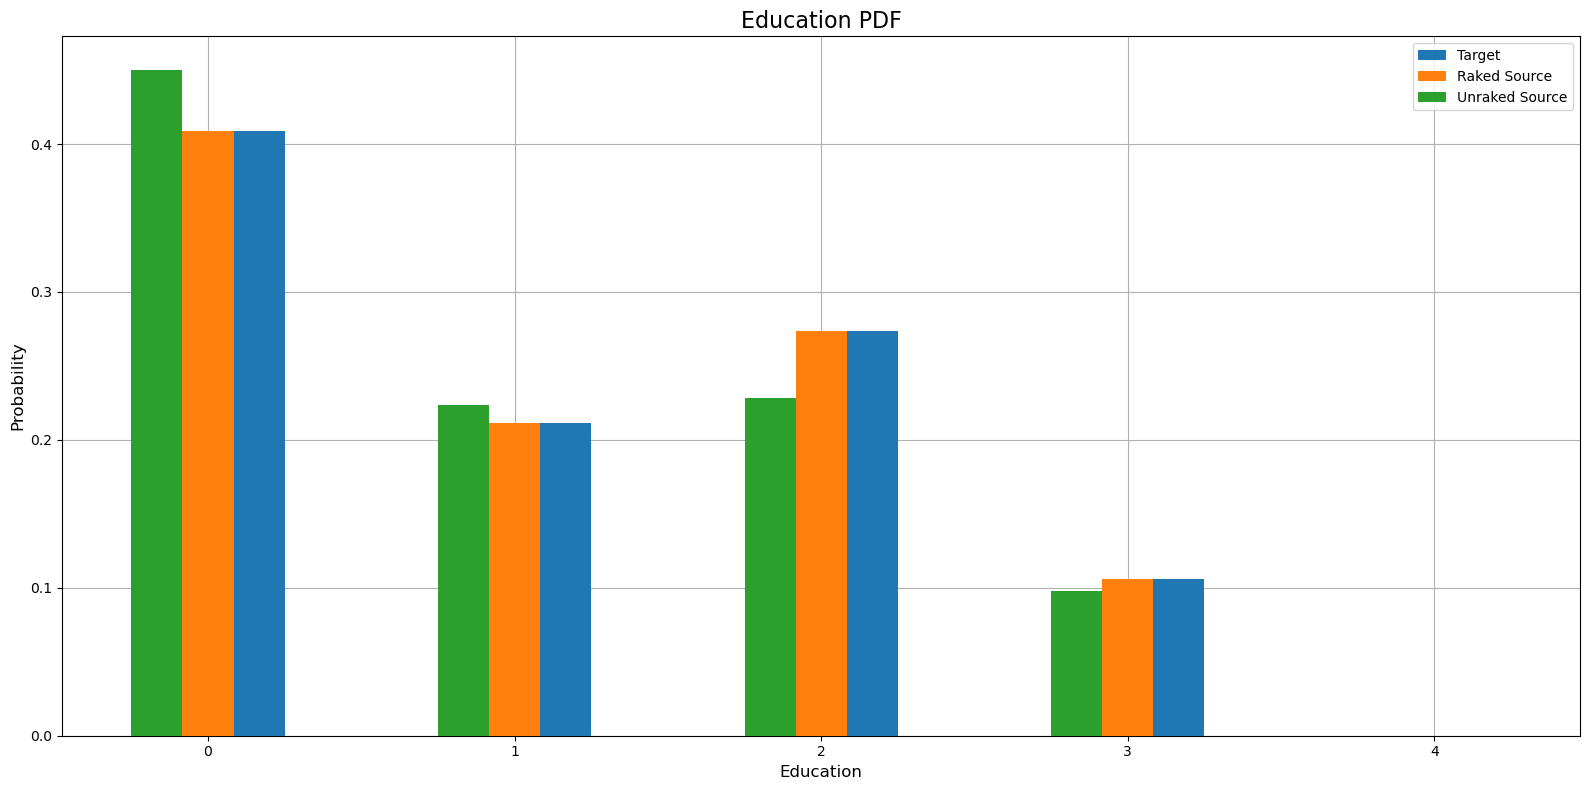

Unraked source PDF : [0.45033 0.22362 0.22834 0.09772 0.     ]
  Raked source PDF : [0.40851 0.21167 0.27385 0.10597 0.     ]
        Target PDF : [0.40851 0.21167 0.27385 0.10597 0.     ]


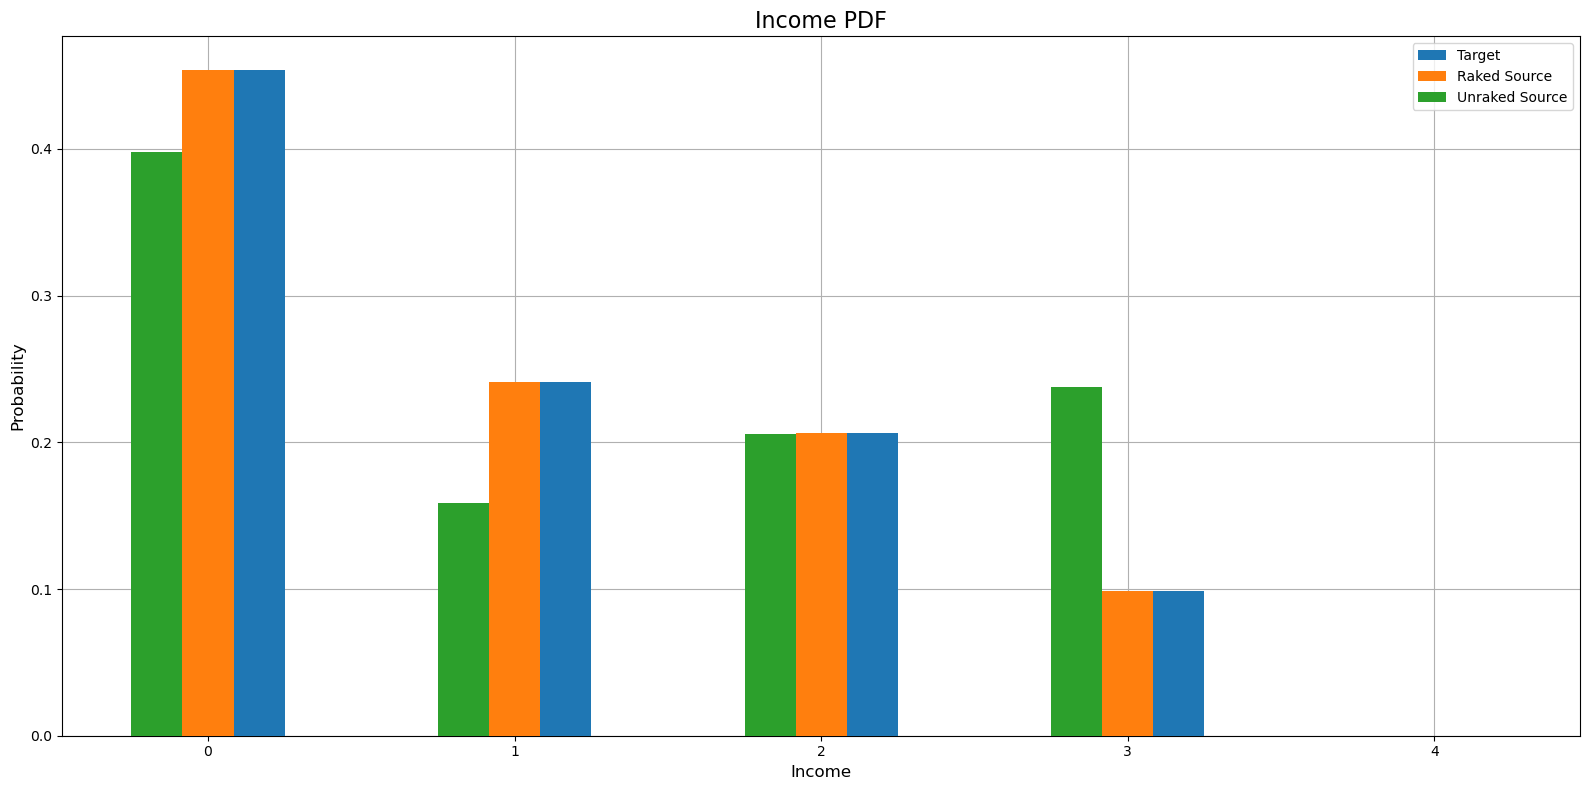

Unraked source PDF : [0.39821 0.15863 0.20554 0.23762 0.     ]
  Raked source PDF : [0.4541  0.24128 0.20626 0.09837 0.     ]
        Target PDF : [0.4541  0.24128 0.20626 0.09837 0.     ]


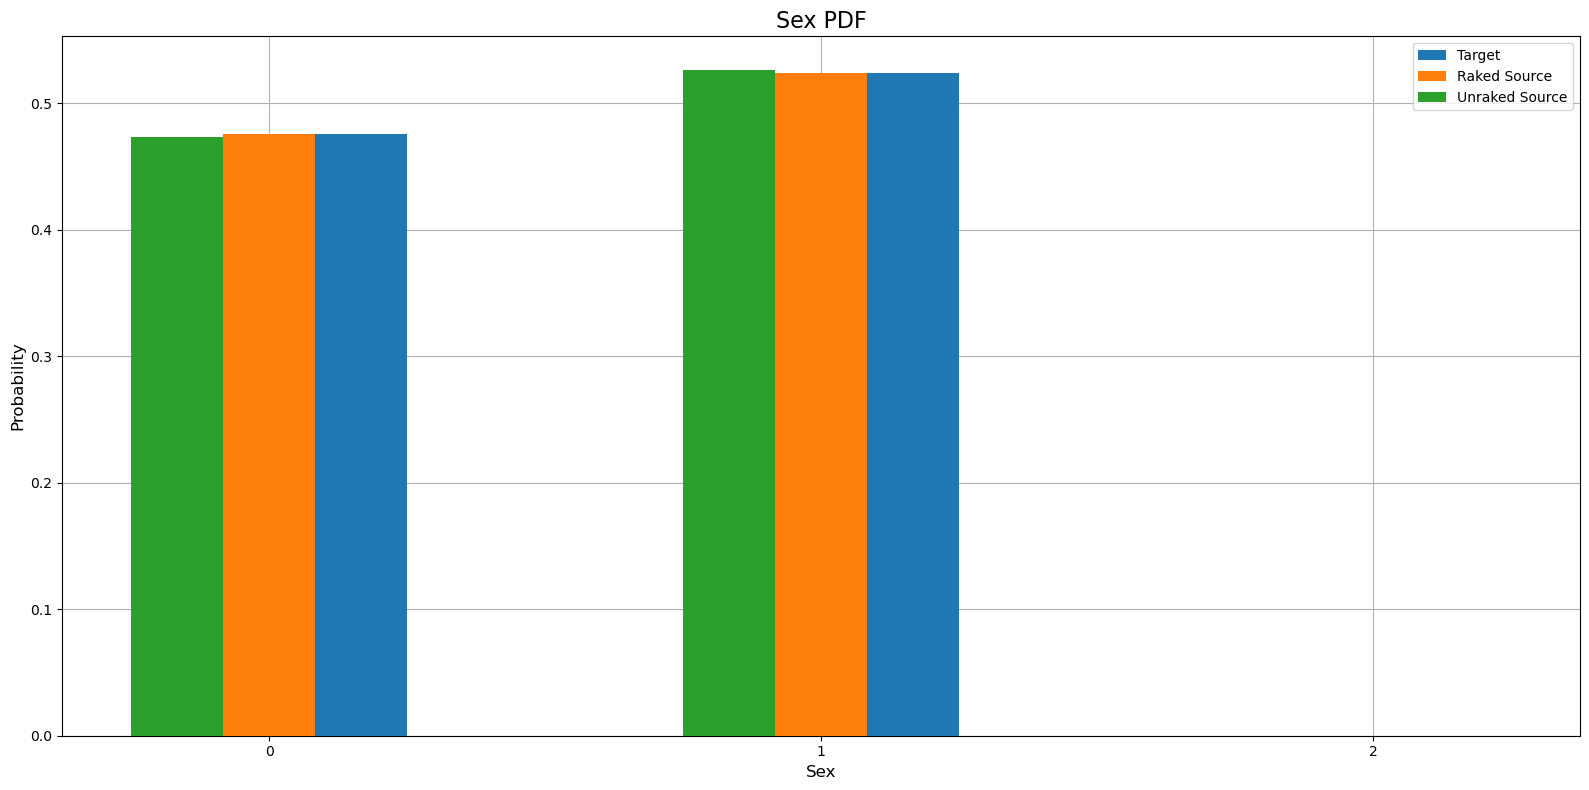

Unraked source PDF : [0.47329 0.52671 0.     ]
  Raked source PDF : [0.47579 0.52421 0.     ]
        Target PDF : [0.47579 0.52421 0.     ]


In [21]:
plot_pdfs(source_unraked_pdfs, source_raked_pdfs, target_pdfs)

#### Write weighted source samples to disk

In [22]:
# insert a column for the weights into the source dataframe
final_df = source_df.assign(Weight = weights)
final_df

,Age,RaceEth,Insurance,Education,Income,Sex,Weight
87252,4,1,0,2,3,0,176.485909
48652,3,1,0,1,0,0,488.738160
3197,4,1,1,0,0,0,409.654645
112542,1,0,0,0,0,1,4333.179878
72659,2,1,0,0,3,0,315.438785
...,...,...,...,...,...,...,...
66462,4,1,0,1,0,1,334.720100
85971,3,0,0,0,0,0,2080.376217
17816,0,4,0,0,3,1,1195.608796
87188,4,1,0,2,3,0,176.485909


In [23]:
# construct output file name from the source file name
output_file = os.path.join(DATA_DIR, OUTPUT_FILE_NAME)

# write output file
final_df.to_csv(output_file, index=False)
print('Wrote file "{0}".'.format(output_file))

Wrote file "data/aou_weighted.csv".


#### Check all zero-weight tuples

Zero weights will be assigned to any source individual with a combination of characteristics **not** appearing in the target population.

Explicitly check that none of these individuals appear in the PUMS data.

In [24]:
zero_df = final_df.loc[final_df['Weight'] == 0]
zero_df

,Age,RaceEth,Insurance,Education,Income,Sex,Weight


In [25]:
print('Found {0} zero-weight source tuples.'.format(len(zero_df)))

Found 0 zero-weight source tuples.


In [26]:
# drop the weight col, not needed for these checks
zero_df = zero_df.drop(columns=['Weight'])

# convert df to set of tuples
zero_wt_tup_set = set(zero_df.itertuples(index=False, name=None))

# drop the weight col from the pums df
pums_no_wt_df = pums_df.drop(columns=[PUMS_WEIGHT_COL])
target_tup_set = set(pums_no_wt_df.itertuples(index=False, name=None))

# these sets should be disjoint, meaning that none of the zero wt tuples occur in the PUMS population
error_population = len(zero_wt_tup_set.intersection(target_tup_set))
    
# this number should be zero
print('Number of zero-weight source samples found in the target population: {0}.'.format(error_population))

Number of zero-weight source samples found in the target population: 0.


#### Find the individuals with the maximum weight

In [27]:
weight_samples = final_df['Weight'].values
nonzero_weights = weight_samples[weight_samples > 0]
min_wt = np.min(nonzero_weights)
max_wt = np.max(nonzero_weights)
print('Min nonzero weight: {0:.3f}'.format(min_wt))
print('Max nonzero weight: {0:.3f}'.format(max_wt))

sorted_weights = sorted(nonzero_weights, reverse=True)
max_wt_df = final_df[final_df['Weight'].isin(sorted_weights[:10])]
max_wt_df

Min nonzero weight: 120.509
Max nonzero weight: 69235.993


,Age,RaceEth,Insurance,Education,Income,Sex,Weight
3293,0,3,1,1,0,0,20120.495474
97207,0,3,0,1,1,0,12918.106954
21816,0,0,0,2,1,0,14499.613365
87056,7,1,0,1,0,0,69235.993427
74912,2,3,1,2,0,0,12475.241361
49418,0,0,0,2,1,1,14472.603375
83599,0,3,0,3,1,0,15997.732654
48976,0,3,1,2,0,0,29411.593381
94177,2,3,1,0,1,1,12794.944436
60674,0,3,1,1,1,0,27471.329150


#### Plot a histogram of the nonzero weights

In [28]:
def plot_weight_distribution(plot_weights, title):
    
    fig = plt.figure(figsize=(16,8))
    plt.hist(plot_weights, bins=100, edgecolor='k', alpha=0.5)
    plt.xlabel('$w_i$', fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.title(title, fontsize=18)
    plt.yscale('log')
    plt.grid()
    plt.show()

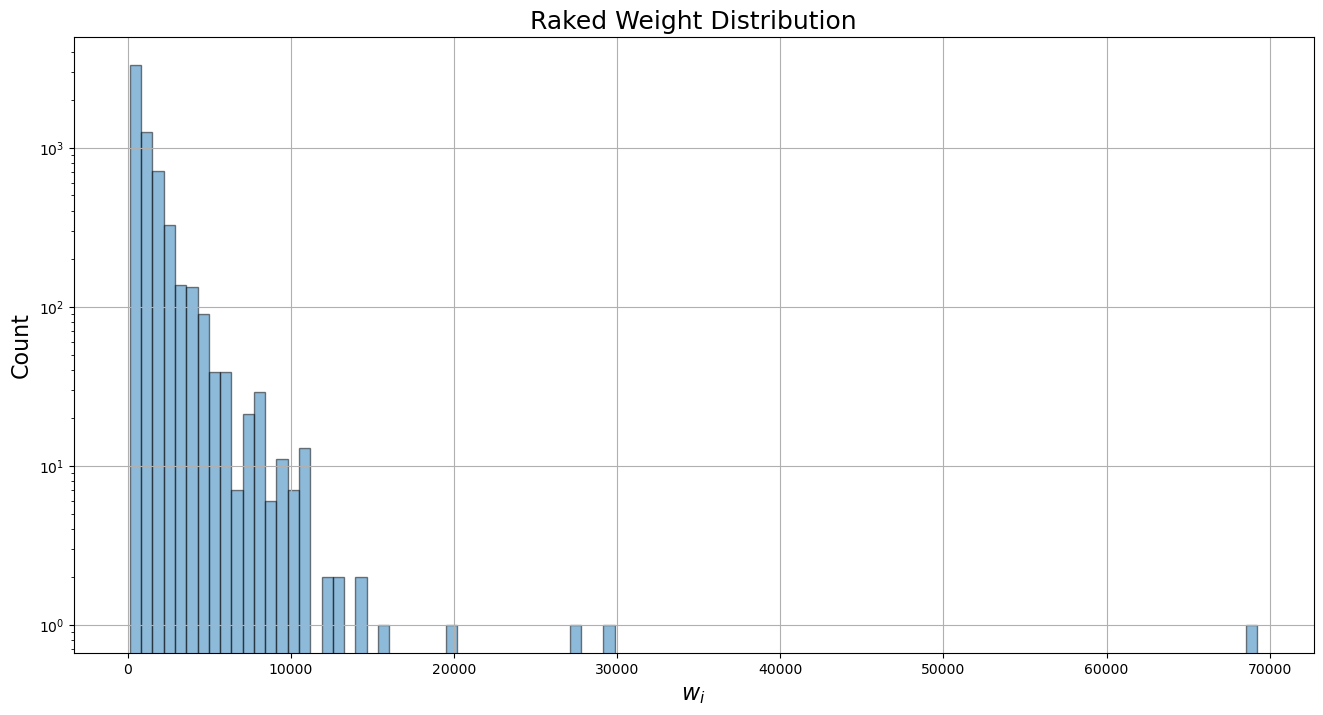

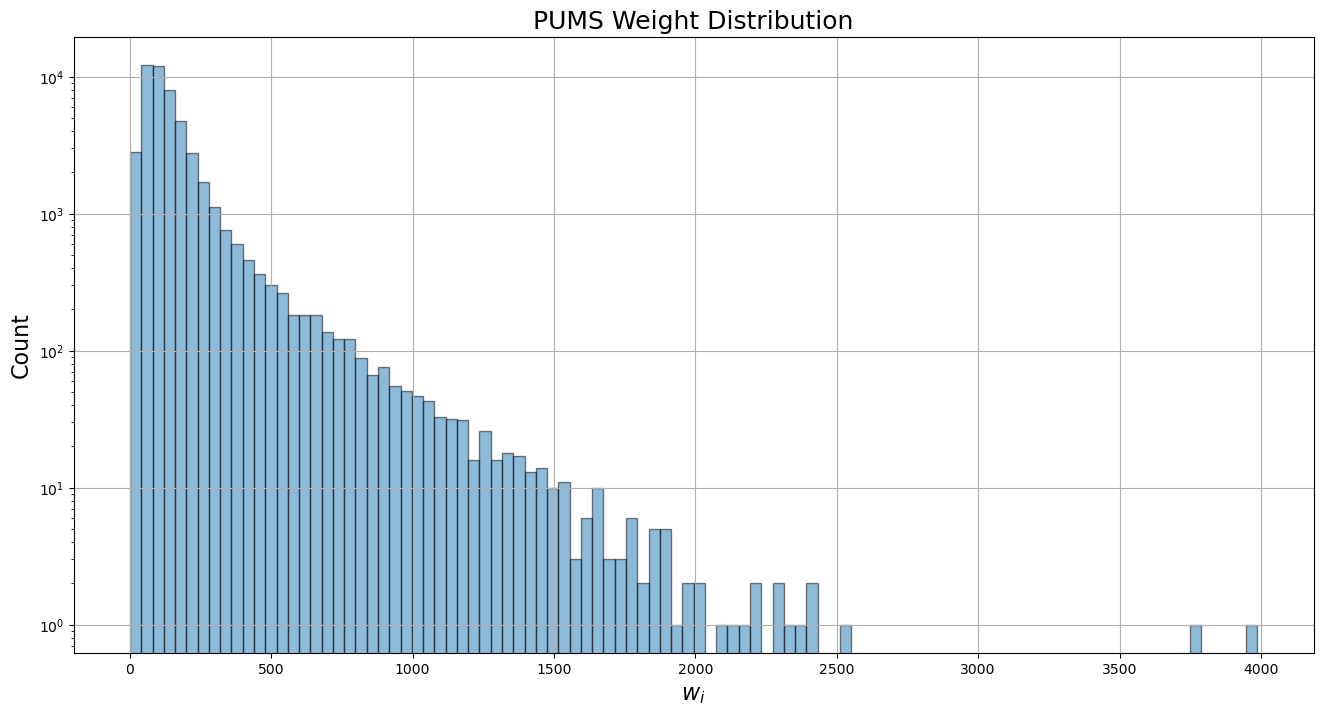

In [29]:
raked_weights = nonzero_weights
plot_weight_distribution(raked_weights, 'Raked Weight Distribution')

target_weights = pums_df['PWGTP'].values
plot_weight_distribution(target_weights, 'PUMS Weight Distribution')

#### Find sets of common tuples

In [30]:
# drop the weight column from the PUMS dataframe, so that only the variable cols remain
target_no_wt_df = pums_df.drop(columns=['PWGTP'])

# get set of (unique) target tuples
target_tuples = set(target_no_wt_df.itertuples(index=False, name=None))

# get set of (unique) source tuples
source_tuples = set(source_df.itertuples(index=False, name=None))

# intersection
shared_tuples = source_tuples.intersection(target_tuples)

print(  'Unique PUMS tuples: {0}'.format(len(target_tuples)))
print('Unique source tuples: {0}'.format(len(source_tuples)))
print('       Shared tuples: {0}'.format(len(shared_tuples)))

Unique PUMS tuples: 1588
Unique source tuples: 1158
       Shared tuples: 974
